# Script IDF

# Librairies

In [5]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from scipy import stats
import scipy.optimize
from functools import partial
from DL_Data import DL_Data

# Données et traitement Extraction des Maximas par blocs: 

In [6]:
Station = ['Aigle','Dole','Payerne','Fretaz','Pully','Nyon','Moleson','Zermatt','Adelboden']
num_sta = 6

Path = "../Database/Precipitations"
df = DL_Data(Path, Station[num_sta])

print('\nDonnées sélectionnées: \n\n\tStation: '+Station[num_sta])


Données sélectionnées: 

	Station: Moleson


In [7]:
N = np.array([1,2,3,4,5,6,7,8,9,10,11,12])
colonne_valeur = df.columns[1]

width_mobile = 15
num_mobiles = df['time'].dt.year.max() - df['time'].dt.year.min() - width_mobile + 1
first_year = df['time'].dt.year.min()
df[colonne_valeur] = pd.to_numeric(df[colonne_valeur])

maximas = np.zeros(shape=[num_mobiles, len(N), width_mobile])

for j in range(num_mobiles):
    print(f'Years: {first_year+j}-{first_year+j+width_mobile} \n')
    for i,n in enumerate(N):
        df_temp = df[(df['time'].dt.year >= first_year+j) & (df['time'].dt.year < first_year + j + width_mobile)].copy()
        rows_to_keep = len(df_temp) - (len(df_temp) % n)
        df_temp = df_temp.iloc[:rows_to_keep]
        df_temp['group'] = np.floor(df_temp.index / n)
        df_temp['averaged'] = df_temp.groupby('group')[colonne_valeur].transform('mean')
        df_temp['year'] = df_temp['time'].dt.year
        pdmaximas = df_temp.groupby('year')['averaged'].max()
        del df_temp
        maximas[j,i] = np.array(pdmaximas)
        maximas[j,i] = np.sort(maximas[j,i])[::-1]

Years: 1982-1997 

Years: 1983-1998 

Years: 1984-1999 

Years: 1985-2000 

Years: 1986-2001 

Years: 1987-2002 

Years: 1988-2003 

Years: 1989-2004 

Years: 1990-2005 

Years: 1991-2006 

Years: 1992-2007 

Years: 1993-2008 

Years: 1994-2009 

Years: 1995-2010 

Years: 1996-2011 

Years: 1997-2012 

Years: 1998-2013 

Years: 1999-2014 

Years: 2000-2015 

Years: 2001-2016 

Years: 2002-2017 

Years: 2003-2018 

Years: 2004-2019 

Years: 2005-2020 

Years: 2006-2021 

Years: 2007-2022 

Years: 2008-2023 

Years: 2009-2024 



# Ajustement des données à la loi de Gumbel:

### Par la méthode de la log-likelihood

In [8]:
parametres = np.zeros(shape=[num_mobiles,len(N),2])

for j in range(num_mobiles):
    for i, n in enumerate(N):
        parametres[j,i] = stats.gumbel_r.fit(maximas[j,i])

alphas, betas = parametres[:,:,0], parametres[:,:,1]


# Verification graphique

j permet de choisir la tranche d'année. Les points empiriques sont obtenus en classant les maximums dans des intervalles de probabilité réguliers


Years: 1983-1998 

(1, 12, 10)


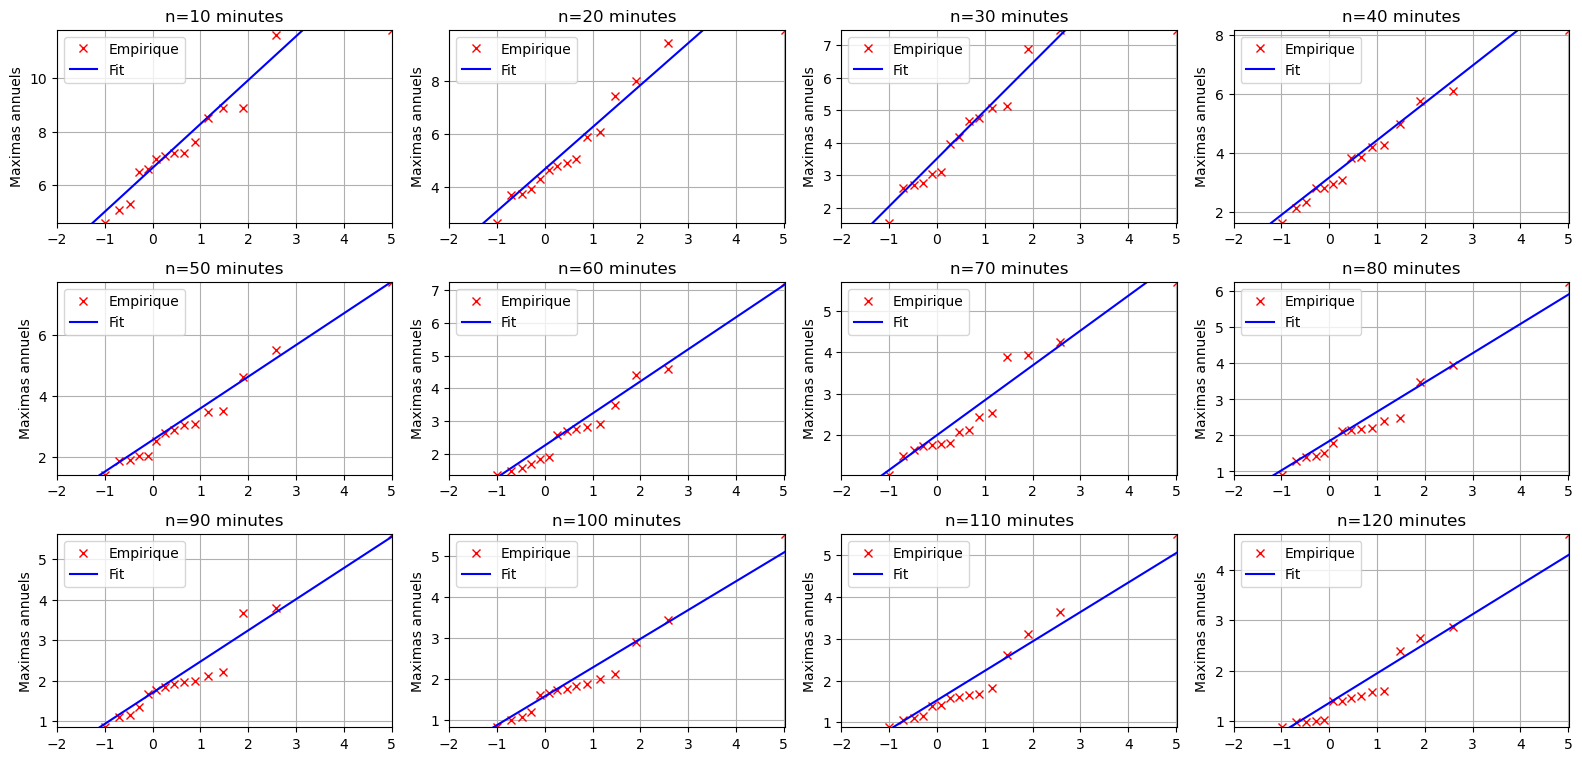

In [9]:
j = 1
print(f'Years: {first_year+j}-{first_year+j+width_mobile} \n')

gumbel_index_emp = -np.log(-np.log(np.arange(1, len(maximas[j,1])+1) / (len(maximas[j,1])+1.e-1)))  
ligne = np.linspace(0,35,10)
gumbel_index_th = (np.tile(ligne, (1, len(N), 1)) - alphas[j, :, np.newaxis]) / betas[j, :, np.newaxis]
print(gumbel_index_th.shape)

plt.figure(figsize=(16, 10))
for i, n in enumerate(N):
    plt.subplot(4, int(len(N)/3), i + 1)
    plt.tight_layout()
    plt.title(f"n={10*n} minutes")
    plt.plot(gumbel_index_emp, np.sort(maximas[j,i]), 'x', color='red', label='Empirique')
    plt.plot(gumbel_index_th[0,i], ligne, '-', color='blue', label='Fit')
    plt.legend()
    plt.ylim(np.min(maximas[j,i]),np.max(maximas[j,i]))
    plt.xlim(-2, np.max(gumbel_index_emp))
    plt.ylabel('Maximas annuels')
    plt.grid('on')

# Fit des courbes IDFs

Définition de la fonction du fit

In [10]:
def montana_complexe(a,b,n,N):
    return a/((N+b)**n)

def montana_complexe_2D(a,b,n,N):
    return a[:,None]/(N[None,:]+b[:,None])**n[:,None]

def residuals_2(params, N, Frequencies):
    a = params[0]
    b = params[1]
    n = params[2]
    model = montana_complexe(a,b,n,N)
    residual = model - Frequencies
    return residual

fit de la fonction définie a priori, T controle les temps de retour d'intêret

In [15]:
import scipy.optimize

T = np.array([2,5,10,20,50,100])
a = np.zeros([num_mobiles,len(T)])
b = np.zeros([num_mobiles,len(T)])
n = np.zeros([num_mobiles,len(T)])
gumbel_index_ = -np.log(-np.log((T-1)/T))
Frequencies = np.einsum('ji,k->jik',betas,gumbel_index_) + alphas[:, :, np.newaxis]

for j in range(num_mobiles):
    for i, t in enumerate(T):
        result = scipy.optimize.least_squares(residuals_2, x0=[a[j,i],b[j,i],n[j,i]], args=(N, Frequencies[j,:,i]))
        a[j,i] = result.x[0]
        b[j,i] = result.x[1]
        n[j,i] = result.x[2]

/var/folders/l5/_vdjp1yd1753bw0l_w612zzm0000gn/T/ipykernel_1293/901418215.py:2: RuntimeWarning: invalid value encountered in power
  return a/((N+b)**n)


# Plot des IDFs

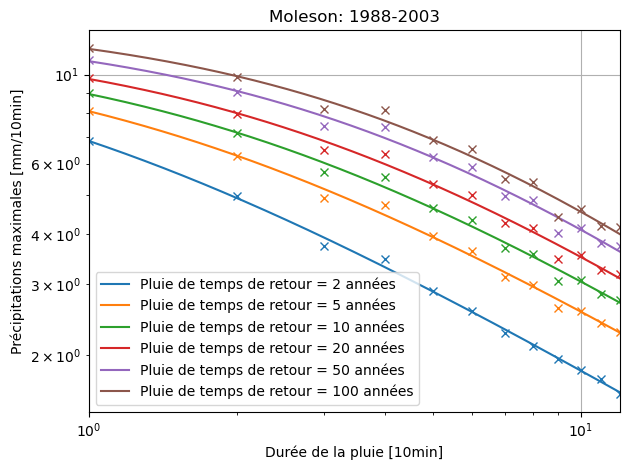

In [16]:
plt.figure()
plt.subplot()
j = 6
for i, t in enumerate(T):
    p1, = plt.plot(np.linspace(N[0],N[-1],1000), montana_complexe(a[j,i],b[j,i],n[j,i],np.linspace(N[0],N[-1],1000)), '-', label=f'Pluie de temps de retour = {t} années')
    color = p1.get_color()
    plt.plot(N, Frequencies[j,:,i],'x',color=color)
plt.xlabel('Durée de la pluie [10min]')
plt.ylabel('Précipitations maximales [mm/10min]')
plt.title(Station[num_sta]+f': {first_year+j}-{first_year+j+width_mobile}')
plt.xscale('log')
plt.yscale('log')
plt.xlim(N[0],N[-1])
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Computing the trend

In [17]:
def curves_diff(i1,i2,agg,precision):
    N = np.arange(agg[0],agg[-1],precision)
    mtn1 = montana_complexe_2D(a[:,i1],b[:,i1],n[:,i1],N)
    mtn2 = montana_complexe_2D(a[:,i2],b[:,i2],n[:,i2],N)
    return np.sum(mtn2 - mtn1, axis=1) / len(N)

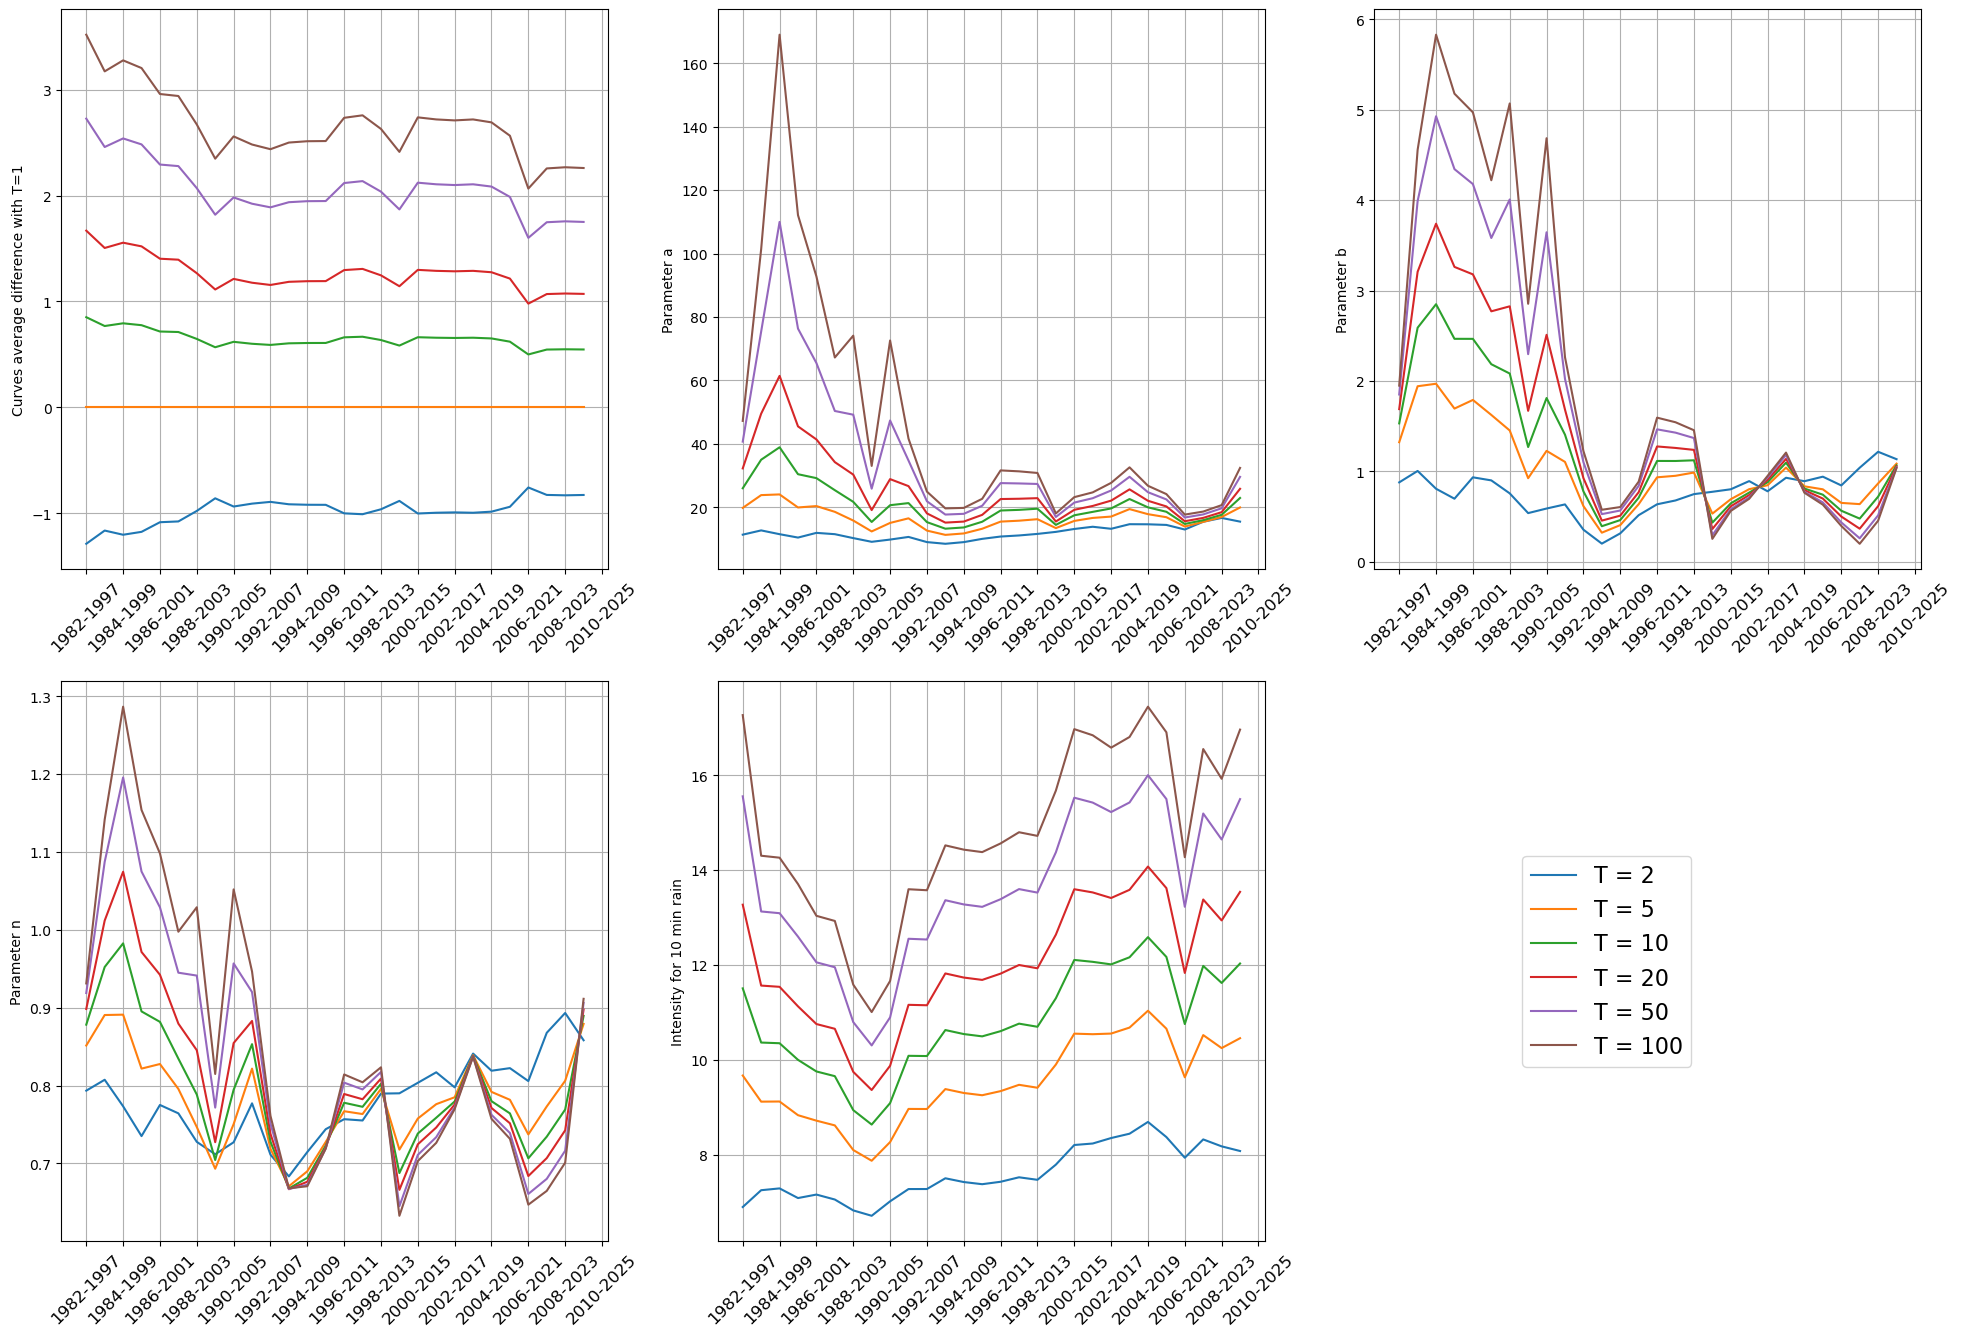

In [18]:
i1 = 1
k=0
x_labels = [f"{first_year+2*i}-{first_year+2*i+width_mobile}" for i in range(num_mobiles//2+1)]

plt.figure(figsize=(24, 16))

for i, t in enumerate(T):
    plt.subplot(2,3,1)
    plt.plot(1981+np.arange(num_mobiles),curves_diff(i1,i,N,0.0001), label=f'T = {t}')
    plt.grid('on')
    plt.ylabel('Curves average difference with T=1')
    plt.xticks(1981+np.arange(0,num_mobiles+1,2), x_labels, rotation=45, fontsize=12)


    plt.subplot(2,3,2)
    plt.plot(1981+np.arange(num_mobiles),a[:,i], label=f'T = {t}')
    plt.grid('on')
    plt.ylabel('Parameter a')
    plt.xticks(1981+np.arange(0,num_mobiles+1,2), x_labels, rotation=45, fontsize=12)


    plt.subplot(2,3,3)
    plt.plot(1981+np.arange(num_mobiles),b[:,i], label=f'T = {t}')
    plt.grid('on')
    plt.ylabel('Parameter b')
    plt.xticks(1981+np.arange(0,num_mobiles+1,2), x_labels, rotation=45, fontsize=12)

    plt.subplot(2,3,4)
    plt.plot(1981+np.arange(num_mobiles),n[:,i], label=f'T = {t}')
    plt.grid('on')
    plt.ylabel('Parameter n')
    plt.xticks(1981+np.arange(0,num_mobiles+1,2), x_labels, rotation=45, fontsize=12)

    plt.subplot(2,3,5)
    plt.plot(1981+np.arange(num_mobiles), montana_complexe(a[:,i], b[:,i], n[:,i], N[k]), label=f'T = {t}')
    plt.grid('on')
    plt.ylabel('Intensity for 10 min rain')
    plt.legend(loc='center right', bbox_to_anchor=(1.8,0.5), fontsize=16)
    plt.xticks(1981+np.arange(0,num_mobiles+1,2), x_labels, rotation=45, fontsize=12)